In [1]:
import numpy as np 
import pandas as pd  
import torch
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 
import torch.nn.functional as F 

data_dir = './fake real faces/'

In [2]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader 
from torchvision import transforms as T,datasets  
from torchvision.models import googlenet

In [3]:
class CNFG:
    epochs =20                             
    lr = 0.001                             
    batch_size = 128              
    img_size = 224
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:{}".format(device))

Device:cuda


In [4]:
data_transform = T.Compose([
                             T.Resize(size=(CNFG.img_size,CNFG.img_size)), # Resizing the image to be 224 by 224
                             T.RandomRotation(degrees=(-20,+20)), #Randomly Rotate Images by +/- 20 degrees, Image argumentation for each epoch
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

In [5]:
data = datasets.ImageFolder(data_dir,       
                    transform=data_transform)
total_count = len(data) 
total_count

2041

In [6]:
train_count = int(0.6 * total_count) 
valid_count = int(0.3 * total_count)
test_count = total_count - train_count - valid_count
train_data, val_data, test_data = torch.utils.data.random_split(data, (train_count, valid_count, test_count))  
print("Train data: {} images".format(len(train_data))) 
print("Validation data: {} images".format(len(val_data))) 
print("Test data: {} images".format(len(test_data)))

Train data: 1224 images
Validation data: 612 images
Test data: 205 images


In [7]:
def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [8]:
train_data.dataset.classes

['fake', 'real']

In [9]:
train_data

In [10]:
trainloader = DataLoader(train_data,batch_size=CNFG.batch_size,shuffle=True)
print("No. of batches in trainloader:{}".format(len(trainloader))) 
print("No. of Total examples:{}".format(len(trainloader.dataset)))

validationloader = DataLoader(val_data,batch_size=CNFG.batch_size,shuffle=True)
print("No. of batches in validationloader:{}".format(len(validationloader)))  
print("No. of Total examples:{}".format(len(validationloader.dataset)))

testloader = DataLoader(test_data,batch_size=CNFG.batch_size,shuffle=True)
print("No. of batches in testloader:{}".format(len(testloader))) 
print("No. of Total examples:{}".format(len(testloader.dataset)))

No. of batches in trainloader:10
No. of Total examples:1224
No. of batches in validationloader:5
No. of Total examples:612
No. of batches in testloader:2
No. of Total examples:205


In [11]:
trainloader

In [12]:
from torch import nn
import torch.nn.functional as F
import timm # PyTorch Image Models

model = googlenet(pretrained=True) #load pretrained model

In [13]:
model.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [14]:
#Updating the pretrained model:
for param in model.parameters():
    param.requires_grad=False 

In [15]:
model.fc = nn.Linear(in_features=1024,out_features = 2, bias=True)

In [16]:
model.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [17]:
from torchsummary import  summary
model.to(device)# move the model to GPU
summary(model,input_size=(3,224,224))

Layer (type:depth-idx)                   Param #
├─BasicConv2d: 1-1                       --
|    └─Conv2d: 2-1                       (9,408)
|    └─BatchNorm2d: 2-2                  (128)
├─MaxPool2d: 1-2                         --
├─BasicConv2d: 1-3                       --
|    └─Conv2d: 2-3                       (4,096)
|    └─BatchNorm2d: 2-4                  (128)
├─BasicConv2d: 1-4                       --
|    └─Conv2d: 2-5                       (110,592)
|    └─BatchNorm2d: 2-6                  (384)
├─MaxPool2d: 1-5                         --
├─Inception: 1-6                         --
|    └─BasicConv2d: 2-7                  --
|    |    └─Conv2d: 3-1                  (12,288)
|    |    └─BatchNorm2d: 3-2             (128)
|    └─Sequential: 2-8                   --
|    |    └─BasicConv2d: 3-3             (18,624)
|    |    └─BasicConv2d: 3-4             (110,848)
|    └─Sequential: 2-9                   --
|    |    └─BasicConv2d: 3-5             (3,104)
|    |    └─BasicC

Layer (type:depth-idx)                   Param #
├─BasicConv2d: 1-1                       --
|    └─Conv2d: 2-1                       (9,408)
|    └─BatchNorm2d: 2-2                  (128)
├─MaxPool2d: 1-2                         --
├─BasicConv2d: 1-3                       --
|    └─Conv2d: 2-3                       (4,096)
|    └─BatchNorm2d: 2-4                  (128)
├─BasicConv2d: 1-4                       --
|    └─Conv2d: 2-5                       (110,592)
|    └─BatchNorm2d: 2-6                  (384)
├─MaxPool2d: 1-5                         --
├─Inception: 1-6                         --
|    └─BasicConv2d: 2-7                  --
|    |    └─Conv2d: 3-1                  (12,288)
|    |    └─BatchNorm2d: 3-2             (128)
|    └─Sequential: 2-8                   --
|    |    └─BasicConv2d: 3-3             (18,624)
|    |    └─BasicConv2d: 3-4             (110,848)
|    └─Sequential: 2-9                   --
|    |    └─BasicConv2d: 3-5             (3,104)
|    |    └─BasicC

In [18]:
class ModelTrainer():
    
    def __init__(self,criterion = None,optimizer = None,schedular = None):
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular 

    
    
    def train_batch_loop(self,model,trainloader):
        
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm(trainloader): 
            
            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = self.criterion(outputs,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(outputs,labels)
            
        return train_loss / len(trainloader), train_acc / len(trainloader) 

    
    def valid_batch_loop(self,model,validloader):
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels in tqdm(validloader):
            
            # move the data to CPU
            images = images.to(device) 
            labels = labels.to(device)
            
            outputs = model(images)
            loss = self.criterion(outputs,labels)
            
            valid_loss += loss.item()
            valid_acc += accuracy(outputs,labels)
            
        return valid_loss / len(validloader), valid_acc / len(validloader)
            
        
    def fit(self,model,trainloader,validloader,epochs):
        
        valid_min_loss = np.Inf 
        
        for i in range(epochs):
            
            model.train() 
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,trainloader) 
            
            model.eval()  
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader) 
            
            if avg_valid_loss <= valid_min_loss :
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),'fake_real_google.pt')
                valid_min_loss = avg_valid_loss

                
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = CNFG.lr)

trainer = ModelTrainer(criterion,optimizer)
trainer.fit(model,trainloader,validationloader,epochs = 20)

  0%|          | 0/10 [00:00<?, ?it/s]

/home/rohithnd/.local/lib/python3.10/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


  0%|          | 0/5 [00:00<?, ?it/s]

Valid_loss decreased inf --> 0.6901750683784484
Epoch : 1 Train Loss : 0.693407 Train Acc : 0.542882
Epoch : 1 Valid Loss : 0.690175 Valid Acc : 0.533687


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Valid_loss decreased 0.6901750683784484 --> 0.6717069983482361
Epoch : 2 Train Loss : 0.671097 Train Acc : 0.585764
Epoch : 2 Valid Loss : 0.671707 Valid Acc : 0.574687


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Valid_loss decreased 0.6717069983482361 --> 0.6697190165519714
Epoch : 3 Train Loss : 0.657434 Train Acc : 0.616146
Epoch : 3 Valid Loss : 0.669719 Valid Acc : 0.601688


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.661274 Train Acc : 0.590625
Epoch : 4 Valid Loss : 0.690695 Valid Acc : 0.540063


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Valid_loss decreased 0.6697190165519714 --> 0.6622379422187805
Epoch : 5 Train Loss : 0.648658 Train Acc : 0.624913
Epoch : 5 Valid Loss : 0.662238 Valid Acc : 0.597375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Valid_loss decreased 0.6622379422187805 --> 0.6467795610427857
Epoch : 6 Train Loss : 0.639056 Train Acc : 0.644531
Epoch : 6 Valid Loss : 0.646780 Valid Acc : 0.608563


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.620040 Train Acc : 0.663194
Epoch : 7 Valid Loss : 0.670612 Valid Acc : 0.596812


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.624309 Train Acc : 0.632986
Epoch : 8 Valid Loss : 0.669421 Valid Acc : 0.586750


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.629464 Train Acc : 0.629687
Epoch : 9 Valid Loss : 0.653178 Valid Acc : 0.627125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.620956 Train Acc : 0.664410
Epoch : 10 Valid Loss : 0.673607 Valid Acc : 0.596125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Valid_loss decreased 0.6467795610427857 --> 0.6424988508224487
Epoch : 11 Train Loss : 0.615387 Train Acc : 0.673090
Epoch : 11 Valid Loss : 0.642499 Valid Acc : 0.628000


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 12 Train Loss : 0.614388 Train Acc : 0.669531
Epoch : 12 Valid Loss : 0.652825 Valid Acc : 0.599250


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 13 Train Loss : 0.602655 Train Acc : 0.673698
Epoch : 13 Valid Loss : 0.652697 Valid Acc : 0.624438


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 14 Train Loss : 0.622063 Train Acc : 0.652431
Epoch : 14 Valid Loss : 0.647990 Valid Acc : 0.611750


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 15 Train Loss : 0.607783 Train Acc : 0.659288
Epoch : 15 Valid Loss : 0.643069 Valid Acc : 0.620375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 16 Train Loss : 0.607057 Train Acc : 0.671788
Epoch : 16 Valid Loss : 0.657633 Valid Acc : 0.585437


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 17 Train Loss : 0.612795 Train Acc : 0.669358
Epoch : 17 Valid Loss : 0.673680 Valid Acc : 0.603938


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 18 Train Loss : 0.602676 Train Acc : 0.674566
Epoch : 18 Valid Loss : 0.644901 Valid Acc : 0.627750


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Valid_loss decreased 0.6424988508224487 --> 0.6419155478477478
Epoch : 19 Train Loss : 0.607171 Train Acc : 0.672396
Epoch : 19 Valid Loss : 0.641916 Valid Acc : 0.612375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 20 Train Loss : 0.584846 Train Acc : 0.705122
Epoch : 20 Valid Loss : 0.650211 Valid Acc : 0.609937


In [20]:
# test predictions
# load torch model 
# model.load_state_dict(torch.load('ocean_19_15.pt'))
# model.load_state_dict(torch.load('ocean_bgg_19_bn.pt'))
model.eval()
test_loss = 0.0
test_acc = 0.0
for images,labels in tqdm(testloader):
        
        # move the data to CPU
        images = images.to(device) 
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs,labels)
        
        test_loss += loss.item()
        test_acc += accuracy(outputs,labels)

print("Test Loss : {:.6f} Test Acc : {:.6f}".format(test_loss / len(testloader), test_acc / len(testloader)))

  0%|          | 0/2 [00:00<?, ?it/s]

Test Loss : 0.638661 Test Acc : 0.607244


In [25]:
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Make predictions

In [2]:
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch.nn.functional as F 
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader 
from torchvision import transforms as T,datasets  
from torchvision.models import googlenet
from torch import nn


data_transform = T.Compose([
                             T.Resize(size=(224,224)), # Resizing the image to be 224 by 224
                            #  T.RandomRotation(degrees=(-20,+20)), #Randomly Rotate Images by +/- 20 degrees, Image argumentation for each epoch
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

]) 


class_map = ['fake','real']

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def predict_image_class_name(image_path,model): 
    
    # show image 
    imshow(data_transform(Image.open(image_path)))

    image = Image.open(image_path)
    image = data_transform(image)
    image = image.unsqueeze(0)
    image = image.to(device) 
    output = model(image)
    output = F.softmax(output,dim = 1)
    print("soft" , output)
    top_p,top_class = output.topk(1,dim = 1) 
    print( top_p , top_class)
    # return "Predicted :", train_data.dataset.classes[top_class.item()]
    return "Predicted :", class_map[top_class.item()]

# device 
device = torch.device("cpu" if torch.cuda.is_available() else "cpu") 

# make realtime predictions 
model = googlenet(pretrained=True) #load pretrained model 
model.fc = nn.Linear(in_features=1024,out_features = 2, bias=True)
model.load_state_dict(torch.load('./fastapi/fake_real_google.pt'))
model.to(device) 

def predict_img(image): 

    INPUT_DIM = 224 
    preprocess = T.Compose([
            T.Resize(INPUT_DIM ),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )])

    imshow(preprocess(Image.open(image)))

    im = Image.open(image)
    im_preprocessed = preprocess(im) 
    batch_img_tensor = torch.unsqueeze(im_preprocessed, 0)
    output = model(batch_img_tensor) 
    confidence = F.softmax(output, dim=1)[0] * 100 
    _, indices = torch.sort(output, descending=True) 
    return [(class_map[idx], confidence[idx].item()) for idx in indices[0][:2]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


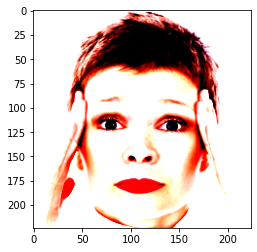

/home/rohithnd/.local/lib/python3.10/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


[('fake', 51.164703369140625), ('real', 48.835296630859375)]

In [3]:
predict_img("./real.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


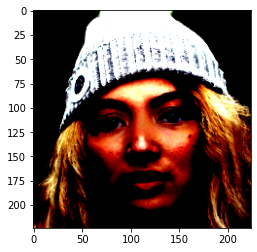

soft tensor([[0.4393, 0.5607]], grad_fn=<SoftmaxBackward0>)
tensor([[0.5607]], grad_fn=<TopkBackward0>) tensor([[1]])


('Predicted :', 'real')

In [4]:
predict_image_class_name('./fake.jpg' , model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


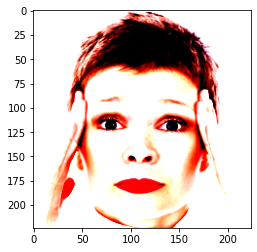

soft tensor([[0.5086, 0.4914]], grad_fn=<SoftmaxBackward0>)
tensor([[0.5086]], grad_fn=<TopkBackward0>) tensor([[0]])


('Predicted :', 'fake')

In [6]:
predict_image_class_name('./real.jpg' , model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


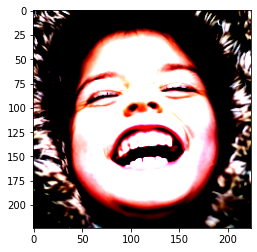

soft tensor([[0.4789, 0.5211]], grad_fn=<SoftmaxBackward0>)
tensor([[0.5211]], grad_fn=<TopkBackward0>) tensor([[1]])


('Predicted :', 'real')

In [7]:
predict_image_class_name('./real_00023.jpg' , model)